# LSTM Travel Time + Speed Prediction - N101.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N101.0')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6393,73,21,2021042800
6407,73,21,2021042800
6421,73,21,2021042800
6435,73,21,2021042800
6449,73,21,2021042800
...,...,...,...
294418,73,21,2021051509
294432,73,21,2021051509
294446,73,21,2021051509
294460,73,21,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,73.0,21.0
2021042801,73.0,21.0
2021042802,73.0,21.0
2021042803,73.0,21.0
2021042804,73.0,21.0
...,...,...
2021051505,73.0,21.0
2021051506,73.0,21.0
2021051507,73.0,21.0


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,0.927728
2021042801,0.927728
2021042802,0.927728
2021042803,0.927728
2021042804,0.927728
...,...
2021051505,0.927728
2021051506,0.927728
2021051507,0.927728


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# LSTM - Time

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 5s 650ms/step - loss: 0.7179 - mae: 0.7009 - rmse: 0.6342 - val_loss: 9.9678e-04 - val_mae: 9.9678e-04 - val_rmse: 9.9678e-04
Epoch 2/300
3/3 [==============================] - 0s 64ms/step - loss: 0.1334 - mae: 0.0463 - rmse: 0.1130 - val_loss: 2.9925e-04 - val_mae: 2.9925e-04 - val_rmse: 2.9925e-04
Epoch 3/300
3/3 [==============================] - 0s 64ms/step - loss: 0.1335 - mae: 0.0451 - rmse: 0.1125 - val_loss: 2.2975e-04 - val_mae: 2.2975e-04 - val_rmse: 2.2975e-04
Epoch 4/300
3/3 [==============================] - 0s 64ms/step - loss: 0.1335 - mae: 0.0451 - rmse: 0.1124 - val_loss: 2.0857e-04 - val_mae: 2.0857e-04 - val_rmse: 2.0857e-04
Epoch 5/300
3/3 [==============================] - 0s 66ms/step - loss: 0.1337 - mae: 0.0449 - rmse: 0.1128 - val_loss: 8.5228e-05 - val_mae: 8.5228e-05 - val_rmse: 8.5228e-05
Epoch 6/300
3/3 [==============================] - 0s 64ms/step - loss: 0.1337 - mae: 0.0447 - rmse: 0.1126 - val_loss:

3/3 [==============================] - 0s 62ms/step - loss: 0.1337 - mae: 0.0445 - rmse: 0.1125 - val_loss: 9.6928e-07 - val_mae: 9.6692e-07 - val_rmse: 9.6928e-07
Epoch 48/300
3/3 [==============================] - 0s 65ms/step - loss: 0.1337 - mae: 0.0445 - rmse: 0.1125 - val_loss: 7.9249e-07 - val_mae: 7.8811e-07 - val_rmse: 7.9249e-07
Epoch 49/300
3/3 [==============================] - 0s 62ms/step - loss: 0.1337 - mae: 0.0445 - rmse: 0.1125 - val_loss: 7.8523e-07 - val_mae: 7.8148e-07 - val_rmse: 7.8523e-07
Epoch 50/300
3/3 [==============================] - 0s 61ms/step - loss: 0.1337 - mae: 0.0445 - rmse: 0.1125 - val_loss: 6.9226e-07 - val_mae: 6.8876e-07 - val_rmse: 6.9226e-07
Epoch 51/300
3/3 [==============================] - 0s 60ms/step - loss: 0.1337 - mae: 0.0445 - rmse: 0.1125 - val_loss: 7.2539e-07 - val_mae: 7.2188e-07 - val_rmse: 7.2539e-07
Epoch 52/300
3/3 [==============================] - 0s 59ms/step - loss: 0.1337 - mae: 0.0445 - rmse: 0.1125 - val_loss: 5.5596e

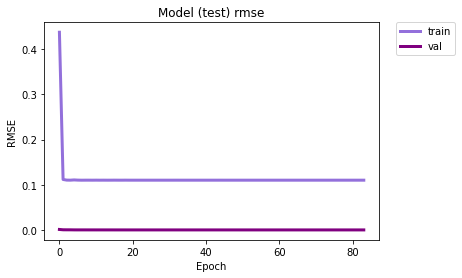

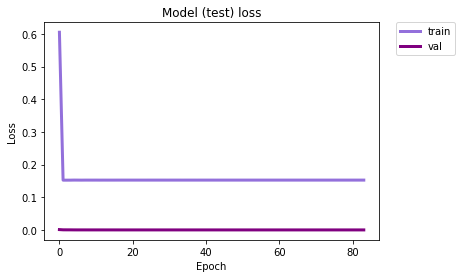

Epoch 1/300
5/5 [==============================] - 0s 62ms/step - loss: 0.2215 - mae: 0.0806 - rmse: 0.1992 - val_loss: 0.0456 - val_mae: 0.0237 - val_rmse: 0.0456
Epoch 2/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2215 - mae: 0.0806 - rmse: 0.1992 - val_loss: 0.0456 - val_mae: 0.0237 - val_rmse: 0.0456
Epoch 3/300
5/5 [==============================] - 0s 49ms/step - loss: 0.2215 - mae: 0.0806 - rmse: 0.1992 - val_loss: 0.0456 - val_mae: 0.0237 - val_rmse: 0.0456
Epoch 4/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2215 - mae: 0.0806 - rmse: 0.1992 - val_loss: 0.0456 - val_mae: 0.0237 - val_rmse: 0.0456
Epoch 5/300
5/5 [==============================] - 0s 52ms/step - loss: 0.2215 - mae: 0.0806 - rmse: 0.1992 - val_loss: 0.0456 - val_mae: 0.0238 - val_rmse: 0.0456
Epoch 6/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2201 - mae: 0.0808 - rmse: 0.1954 - val_loss: 0.0414 - val_mae: 0.0305 - val_rmse: 0.0414
Epoch 7/300
5/5 

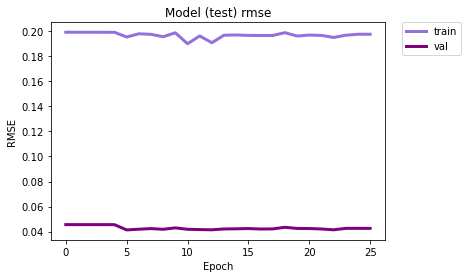

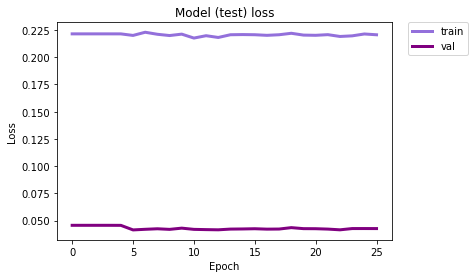

Epoch 1/300
7/7 [==============================] - 0s 58ms/step - loss: 0.1622 - mae: 0.0711 - rmse: 0.1539 - val_loss: 0.0334 - val_mae: 0.0122 - val_rmse: 0.0204
Epoch 2/300
7/7 [==============================] - 0s 51ms/step - loss: 0.1610 - mae: 0.0656 - rmse: 0.1526 - val_loss: 0.0334 - val_mae: 0.0130 - val_rmse: 0.0209
Epoch 3/300
7/7 [==============================] - 0s 51ms/step - loss: 0.1604 - mae: 0.0671 - rmse: 0.1518 - val_loss: 0.0335 - val_mae: 0.0148 - val_rmse: 0.0220
Epoch 4/300
7/7 [==============================] - 0s 50ms/step - loss: 0.1619 - mae: 0.0677 - rmse: 0.1536 - val_loss: 0.0335 - val_mae: 0.0119 - val_rmse: 0.0202
Epoch 5/300
7/7 [==============================] - 0s 47ms/step - loss: 0.1609 - mae: 0.0664 - rmse: 0.1527 - val_loss: 0.0334 - val_mae: 0.0124 - val_rmse: 0.0205
Epoch 6/300
7/7 [==============================] - 0s 49ms/step - loss: 0.1606 - mae: 0.0669 - rmse: 0.1523 - val_loss: 0.0334 - val_mae: 0.0130 - val_rmse: 0.0209
Epoch 7/300
7/7 

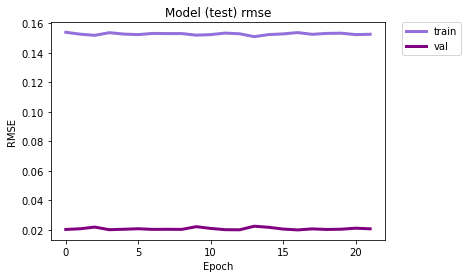

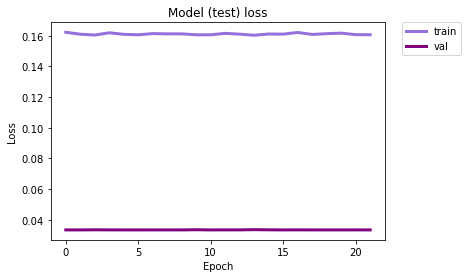

Epoch 1/300
9/9 [==============================] - 0s 51ms/step - loss: 0.1276 - mae: 0.0528 - rmse: 0.1185 - val_loss: 0.0586 - val_mae: 0.0220 - val_rmse: 0.0633
Epoch 2/300
9/9 [==============================] - 0s 45ms/step - loss: 0.1275 - mae: 0.0508 - rmse: 0.1186 - val_loss: 0.0589 - val_mae: 0.0212 - val_rmse: 0.0637
Epoch 3/300
9/9 [==============================] - 0s 47ms/step - loss: 0.1272 - mae: 0.0486 - rmse: 0.1180 - val_loss: 0.0590 - val_mae: 0.0211 - val_rmse: 0.0637
Epoch 4/300
9/9 [==============================] - 0s 51ms/step - loss: 0.1273 - mae: 0.0486 - rmse: 0.1181 - val_loss: 0.0591 - val_mae: 0.0210 - val_rmse: 0.0638
Epoch 5/300
9/9 [==============================] - 0s 49ms/step - loss: 0.1272 - mae: 0.0486 - rmse: 0.1179 - val_loss: 0.0590 - val_mae: 0.0211 - val_rmse: 0.0638
Epoch 6/300
9/9 [==============================] - 0s 48ms/step - loss: 0.1271 - mae: 0.0496 - rmse: 0.1180 - val_loss: 0.0590 - val_mae: 0.0210 - val_rmse: 0.0638
Epoch 7/300
9/9 

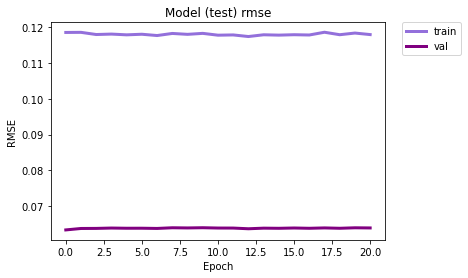

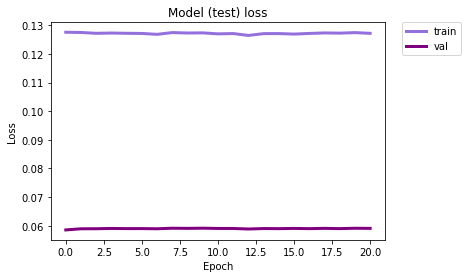

Epoch 1/300
11/11 [==============================] - 1s 50ms/step - loss: 0.1170 - mae: 0.0462 - rmse: 0.1128 - val_loss: 0.0856 - val_mae: 0.0329 - val_rmse: 0.0829
Epoch 2/300
11/11 [==============================] - 1s 46ms/step - loss: 0.1166 - mae: 0.0459 - rmse: 0.1124 - val_loss: 0.0853 - val_mae: 0.0335 - val_rmse: 0.0826
Epoch 3/300
11/11 [==============================] - 1s 47ms/step - loss: 0.1158 - mae: 0.0470 - rmse: 0.1114 - val_loss: 0.0841 - val_mae: 0.0364 - val_rmse: 0.0814
Epoch 4/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1165 - mae: 0.0497 - rmse: 0.1120 - val_loss: 0.0836 - val_mae: 0.0379 - val_rmse: 0.0809
Epoch 5/300
11/11 [==============================] - 1s 48ms/step - loss: 0.1168 - mae: 0.0492 - rmse: 0.1124 - val_loss: 0.0844 - val_mae: 0.0355 - val_rmse: 0.0818
Epoch 6/300
11/11 [==============================] - 1s 49ms/step - loss: 0.1161 - mae: 0.0488 - rmse: 0.1118 - val_loss: 0.0844 - val_mae: 0.0356 - val_rmse: 0.0817
Epoc

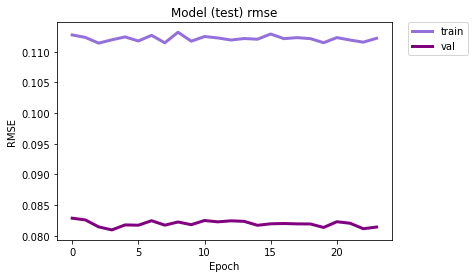

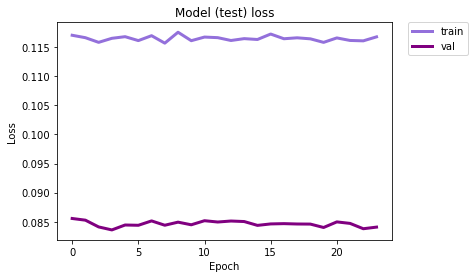

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.99092656
Transformed yhat 46.45247
yhat -0.99097925
Transformed yhat 46.45174
yhat -0.991027
Transformed yhat 46.45108
yhat -0.99106944
Transformed yhat 46.450493
yhat -0.99110717
Transformed yhat 46.44997
yhat -0.99114054
Transformed yhat 46.44951
yhat -0.99126464
Transformed yhat 46.44779
yhat -0.9913807
Transformed yhat 46.446182
yhat -0.9914211
Transformed yhat 46.445625
yhat -0.9915358
Transformed yhat 46.44404
yhat -0.99153197
Transformed yhat 46.44409
yhat -0.9915089
Transformed yhat 46.444412
Real data: [46.32692308 46.32692308 46.32692308 46.32692308 46.32692308 47.67889019
 47.79155412 46.91840869 48.09309581 46.58538738 46.32692308 46.32692308
 46.32692308 46.32692308 46.32692308 46.32692308 46.32692308 46.32692308
 46.32692308 46.32692308 46.32692308 46.32692308 46.32692308 46.32692308]
Forecasting values: [46.5, 46.5, 46.5, 46.5, 46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46.4]


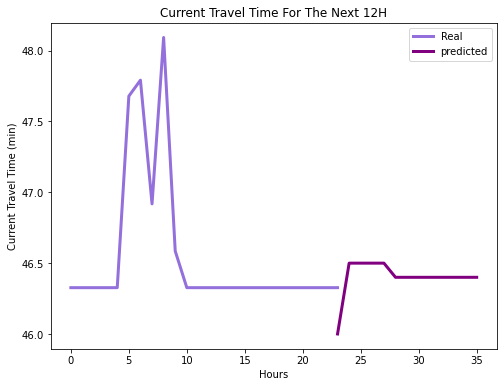

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.0',forecasts[i],hour[i]
        writer.writerow(d)
        

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 9s 941ms/step - loss: 0.7402 - mae: 0.7289 - rmse: 0.6610 - val_loss: 0.0643 - val_mae: 0.0643 - val_rmse: 0.0643
Epoch 2/300
3/3 [==============================] - 0s 80ms/step - loss: 0.1603 - mae: 0.0859 - rmse: 0.1396 - val_loss: 0.1162 - val_mae: 0.1161 - val_rmse: 0.1162
Epoch 3/300
3/3 [==============================] - 0s 108ms/step - loss: 0.2052 - mae: 0.1203 - rmse: 0.1842 - val_loss: 0.0651 - val_mae: 0.0651 - val_rmse: 0.0651
Epoch 4/300
3/3 [==============================] - 0s 68ms/step - loss: 0.1635 - mae: 0.0824 - rmse: 0.1444 - val_loss: 0.0172 - val_mae: 0.0171 - val_rmse: 0.0172
Epoch 5/300
3/3 [==============================] - 0s 70ms/step - loss: 0.1544 - mae: 0.0786 - rmse: 0.1379 - val_loss: 0.0236 - val_mae: 0.0236 - val_rmse: 0.0236
Epoch 6/300
3/3 [==============================] - 0s 91ms/step - loss: 0.1453 - mae: 0.0837 - rmse: 0.1279 - val_loss: 0.0457 - val_mae: 0.0456 - val_rmse: 0.0457
Epoch 7/300
3/

Epoch 51/300
3/3 [==============================] - 0s 68ms/step - loss: 0.1565 - mae: 0.0824 - rmse: 0.1375 - val_loss: 0.0219 - val_mae: 0.0219 - val_rmse: 0.0219
Epoch 52/300
3/3 [==============================] - 0s 82ms/step - loss: 0.1464 - mae: 0.0780 - rmse: 0.1264 - val_loss: 0.0258 - val_mae: 0.0258 - val_rmse: 0.0258
Epoch 53/300
3/3 [==============================] - 0s 83ms/step - loss: 0.1497 - mae: 0.0856 - rmse: 0.1288 - val_loss: 0.0020 - val_mae: 0.0020 - val_rmse: 0.0020
Epoch 54/300
3/3 [==============================] - 0s 66ms/step - loss: 0.1443 - mae: 0.0790 - rmse: 0.1233 - val_loss: 0.0459 - val_mae: 0.0459 - val_rmse: 0.0459
Epoch 55/300
3/3 [==============================] - 0s 142ms/step - loss: 0.1570 - mae: 0.0851 - rmse: 0.1362 - val_loss: 0.0297 - val_mae: 0.0297 - val_rmse: 0.0297
Epoch 56/300
3/3 [==============================] - 0s 65ms/step - loss: 0.1458 - mae: 0.0872 - rmse: 0.1303 - val_loss: 0.0590 - val_mae: 0.0590 - val_rmse: 0.0590
Epoch 57/

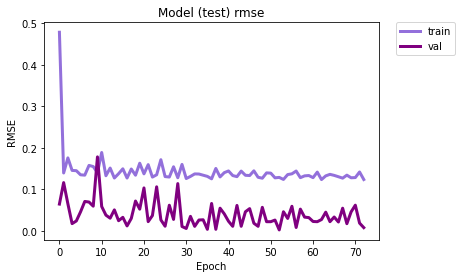

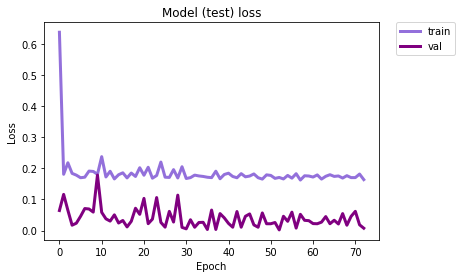

Epoch 1/300
5/5 [==============================] - 0s 93ms/step - loss: 0.2293 - mae: 0.1128 - rmse: 0.2074 - val_loss: 0.0575 - val_mae: 0.0506 - val_rmse: 0.0575
Epoch 2/300
5/5 [==============================] - 0s 103ms/step - loss: 0.2299 - mae: 0.1115 - rmse: 0.2085 - val_loss: 0.0544 - val_mae: 0.0484 - val_rmse: 0.0544
Epoch 3/300
5/5 [==============================] - 0s 102ms/step - loss: 0.2236 - mae: 0.1103 - rmse: 0.2058 - val_loss: 0.0550 - val_mae: 0.0489 - val_rmse: 0.0550
Epoch 4/300
5/5 [==============================] - 0s 104ms/step - loss: 0.2266 - mae: 0.1094 - rmse: 0.2067 - val_loss: 0.0544 - val_mae: 0.0484 - val_rmse: 0.0544
Epoch 5/300
5/5 [==============================] - 0s 58ms/step - loss: 0.2304 - mae: 0.1128 - rmse: 0.2070 - val_loss: 0.0560 - val_mae: 0.0496 - val_rmse: 0.0560
Epoch 6/300
5/5 [==============================] - 0s 105ms/step - loss: 0.2286 - mae: 0.1127 - rmse: 0.2101 - val_loss: 0.0573 - val_mae: 0.0504 - val_rmse: 0.0573
Epoch 7/300


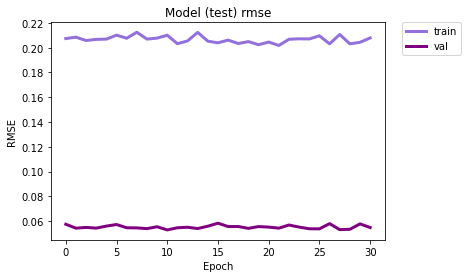

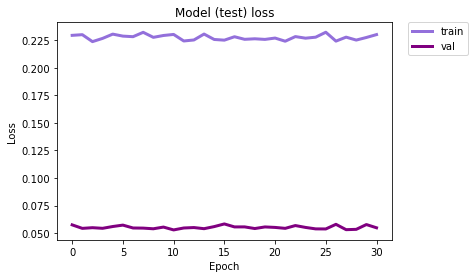

Epoch 1/300
7/7 [==============================] - 0s 62ms/step - loss: 0.1689 - mae: 0.0867 - rmse: 0.1617 - val_loss: 0.0654 - val_mae: 0.0593 - val_rmse: 0.0651
Epoch 2/300
7/7 [==============================] - 0s 51ms/step - loss: 0.1741 - mae: 0.0913 - rmse: 0.1690 - val_loss: 0.0582 - val_mae: 0.0518 - val_rmse: 0.0563
Epoch 3/300
7/7 [==============================] - 0s 49ms/step - loss: 0.1724 - mae: 0.0878 - rmse: 0.1659 - val_loss: 0.0581 - val_mae: 0.0516 - val_rmse: 0.0561
Epoch 4/300
7/7 [==============================] - 0s 56ms/step - loss: 0.1738 - mae: 0.0901 - rmse: 0.1689 - val_loss: 0.0614 - val_mae: 0.0552 - val_rmse: 0.0602
Epoch 5/300
7/7 [==============================] - 0s 56ms/step - loss: 0.1750 - mae: 0.0905 - rmse: 0.1689 - val_loss: 0.0589 - val_mae: 0.0525 - val_rmse: 0.0571
Epoch 6/300
7/7 [==============================] - 0s 54ms/step - loss: 0.1727 - mae: 0.0900 - rmse: 0.1667 - val_loss: 0.0612 - val_mae: 0.0550 - val_rmse: 0.0600
Epoch 7/300
7/7 

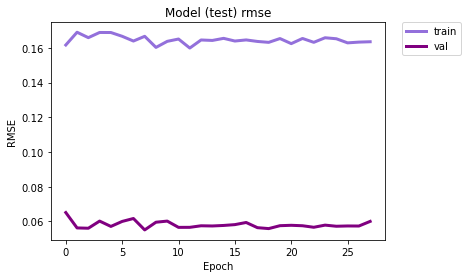

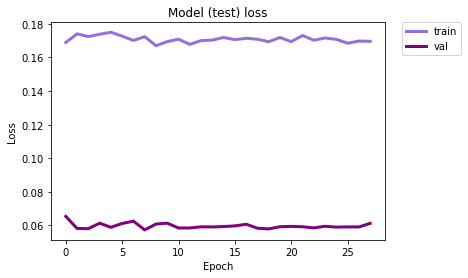

Epoch 1/300
9/9 [==============================] - 0s 53ms/step - loss: 0.1442 - mae: 0.0795 - rmse: 0.1373 - val_loss: 0.0728 - val_mae: 0.0514 - val_rmse: 0.0757
Epoch 2/300
9/9 [==============================] - 0s 47ms/step - loss: 0.1457 - mae: 0.0779 - rmse: 0.1380 - val_loss: 0.0724 - val_mae: 0.0498 - val_rmse: 0.0754
Epoch 3/300
9/9 [==============================] - 0s 50ms/step - loss: 0.1465 - mae: 0.0782 - rmse: 0.1398 - val_loss: 0.0723 - val_mae: 0.0491 - val_rmse: 0.0753
Epoch 4/300
9/9 [==============================] - 0s 49ms/step - loss: 0.1442 - mae: 0.0766 - rmse: 0.1368 - val_loss: 0.0722 - val_mae: 0.0481 - val_rmse: 0.0752
Epoch 5/300
9/9 [==============================] - 0s 50ms/step - loss: 0.1475 - mae: 0.0776 - rmse: 0.1394 - val_loss: 0.0722 - val_mae: 0.0477 - val_rmse: 0.0752
Epoch 6/300
9/9 [==============================] - 0s 53ms/step - loss: 0.1484 - mae: 0.0813 - rmse: 0.1402 - val_loss: 0.0722 - val_mae: 0.0471 - val_rmse: 0.0752
Epoch 7/300
9/9 

Epoch 51/300
9/9 [==============================] - 1s 72ms/step - loss: 0.1436 - mae: 0.0791 - rmse: 0.1360 - val_loss: 0.0721 - val_mae: 0.0480 - val_rmse: 0.0751
Epoch 52/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1428 - mae: 0.0791 - rmse: 0.1352 - val_loss: 0.0721 - val_mae: 0.0475 - val_rmse: 0.0751
Epoch 53/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1440 - mae: 0.0780 - rmse: 0.1366 - val_loss: 0.0721 - val_mae: 0.0485 - val_rmse: 0.0751
Epoch 54/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1425 - mae: 0.0779 - rmse: 0.1359 - val_loss: 0.0722 - val_mae: 0.0491 - val_rmse: 0.0751
Epoch 55/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1440 - mae: 0.0777 - rmse: 0.1367 - val_loss: 0.0722 - val_mae: 0.0491 - val_rmse: 0.0751
Epoch 56/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1424 - mae: 0.0785 - rmse: 0.1349 - val_loss: 0.0722 - val_mae: 0.0495 - val_rmse: 0.0752
Epoch 57/3

Epoch 101/300
9/9 [==============================] - 1s 112ms/step - loss: 0.1405 - mae: 0.0797 - rmse: 0.1342 - val_loss: 0.0720 - val_mae: 0.0488 - val_rmse: 0.0749
Epoch 102/300
9/9 [==============================] - 1s 90ms/step - loss: 0.1404 - mae: 0.0778 - rmse: 0.1328 - val_loss: 0.0720 - val_mae: 0.0487 - val_rmse: 0.0749
Epoch 103/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1419 - mae: 0.0783 - rmse: 0.1346 - val_loss: 0.0719 - val_mae: 0.0479 - val_rmse: 0.0749
Epoch 104/300
9/9 [==============================] - 1s 75ms/step - loss: 0.1413 - mae: 0.0789 - rmse: 0.1337 - val_loss: 0.0719 - val_mae: 0.0484 - val_rmse: 0.0749
Epoch 105/300
9/9 [==============================] - 1s 76ms/step - loss: 0.1395 - mae: 0.0769 - rmse: 0.1324 - val_loss: 0.0719 - val_mae: 0.0483 - val_rmse: 0.0749
Epoch 106/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1412 - mae: 0.0790 - rmse: 0.1335 - val_loss: 0.0719 - val_mae: 0.0485 - val_rmse: 0.0749
Epo

9/9 [==============================] - 0s 49ms/step - loss: 0.1379 - mae: 0.0755 - rmse: 0.1312 - val_loss: 0.0718 - val_mae: 0.0487 - val_rmse: 0.0746
Epoch 151/300
9/9 [==============================] - 0s 47ms/step - loss: 0.1327 - mae: 0.0753 - rmse: 0.1262 - val_loss: 0.0717 - val_mae: 0.0483 - val_rmse: 0.0746
Epoch 152/300
9/9 [==============================] - 0s 48ms/step - loss: 0.1327 - mae: 0.0746 - rmse: 0.1260 - val_loss: 0.0717 - val_mae: 0.0484 - val_rmse: 0.0746
Epoch 153/300
9/9 [==============================] - 0s 54ms/step - loss: 0.1353 - mae: 0.0755 - rmse: 0.1282 - val_loss: 0.0717 - val_mae: 0.0485 - val_rmse: 0.0746
Epoch 154/300
9/9 [==============================] - 1s 58ms/step - loss: 0.1343 - mae: 0.0752 - rmse: 0.1273 - val_loss: 0.0718 - val_mae: 0.0489 - val_rmse: 0.0746
Epoch 155/300
9/9 [==============================] - 0s 49ms/step - loss: 0.1334 - mae: 0.0753 - rmse: 0.1269 - val_loss: 0.0717 - val_mae: 0.0486 - val_rmse: 0.0746
Epoch 156/300
9/9 

9/9 [==============================] - 1s 71ms/step - loss: 0.1221 - mae: 0.0696 - rmse: 0.1164 - val_loss: 0.0715 - val_mae: 0.0485 - val_rmse: 0.0743
Epoch 200/300
9/9 [==============================] - 1s 65ms/step - loss: 0.1264 - mae: 0.0716 - rmse: 0.1203 - val_loss: 0.0714 - val_mae: 0.0476 - val_rmse: 0.0742
Epoch 201/300
9/9 [==============================] - 1s 94ms/step - loss: 0.1265 - mae: 0.0710 - rmse: 0.1198 - val_loss: 0.0715 - val_mae: 0.0479 - val_rmse: 0.0742
Epoch 202/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1290 - mae: 0.0714 - rmse: 0.1228 - val_loss: 0.0714 - val_mae: 0.0473 - val_rmse: 0.0742
Epoch 203/300
9/9 [==============================] - 1s 66ms/step - loss: 0.1269 - mae: 0.0713 - rmse: 0.1210 - val_loss: 0.0715 - val_mae: 0.0478 - val_rmse: 0.0742
Epoch 204/300
9/9 [==============================] - 1s 74ms/step - loss: 0.1259 - mae: 0.0702 - rmse: 0.1202 - val_loss: 0.0715 - val_mae: 0.0478 - val_rmse: 0.0742
Epoch 205/300
9/9 

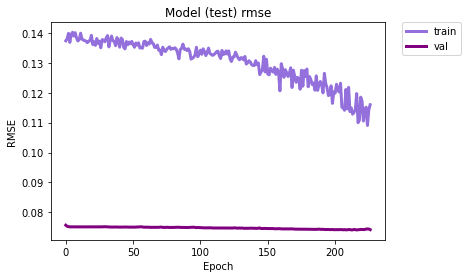

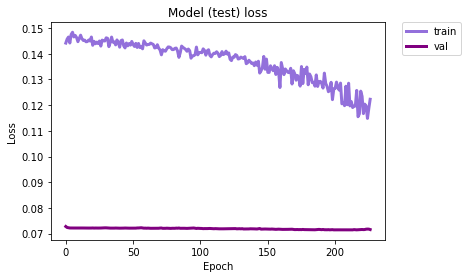

Epoch 1/300
11/11 [==============================] - 1s 73ms/step - loss: 0.1180 - mae: 0.0680 - rmse: 0.1135 - val_loss: 0.0927 - val_mae: 0.0558 - val_rmse: 0.0904
Epoch 2/300
11/11 [==============================] - 1s 47ms/step - loss: 0.1162 - mae: 0.0688 - rmse: 0.1117 - val_loss: 0.0907 - val_mae: 0.0538 - val_rmse: 0.0885
Epoch 3/300
11/11 [==============================] - 1s 47ms/step - loss: 0.1150 - mae: 0.0666 - rmse: 0.1110 - val_loss: 0.0925 - val_mae: 0.0556 - val_rmse: 0.0903
Epoch 4/300
11/11 [==============================] - 1s 74ms/step - loss: 0.1168 - mae: 0.0664 - rmse: 0.1125 - val_loss: 0.0912 - val_mae: 0.0543 - val_rmse: 0.0890
Epoch 5/300
11/11 [==============================] - 1s 86ms/step - loss: 0.1180 - mae: 0.0689 - rmse: 0.1142 - val_loss: 0.0922 - val_mae: 0.0553 - val_rmse: 0.0900
Epoch 6/300
11/11 [==============================] - 1s 96ms/step - loss: 0.1114 - mae: 0.0658 - rmse: 0.1079 - val_loss: 0.0909 - val_mae: 0.0540 - val_rmse: 0.0887
Epoc

11/11 [==============================] - 1s 64ms/step - loss: 0.1059 - mae: 0.0625 - rmse: 0.1026 - val_loss: 0.0882 - val_mae: 0.0533 - val_rmse: 0.0863
Epoch 51/300
11/11 [==============================] - 1s 58ms/step - loss: 0.1030 - mae: 0.0607 - rmse: 0.0991 - val_loss: 0.0884 - val_mae: 0.0536 - val_rmse: 0.0865
Epoch 52/300
11/11 [==============================] - 1s 64ms/step - loss: 0.1060 - mae: 0.0614 - rmse: 0.1023 - val_loss: 0.0903 - val_mae: 0.0554 - val_rmse: 0.0883
Epoch 53/300
11/11 [==============================] - 1s 61ms/step - loss: 0.1097 - mae: 0.0662 - rmse: 0.1060 - val_loss: 0.0889 - val_mae: 0.0541 - val_rmse: 0.0870
Epoch 54/300
11/11 [==============================] - 1s 63ms/step - loss: 0.1085 - mae: 0.0646 - rmse: 0.1050 - val_loss: 0.0895 - val_mae: 0.0547 - val_rmse: 0.0875
Epoch 55/300
11/11 [==============================] - 1s 65ms/step - loss: 0.1079 - mae: 0.0619 - rmse: 0.1044 - val_loss: 0.0908 - val_mae: 0.0561 - val_rmse: 0.0889
Epoch 56/30

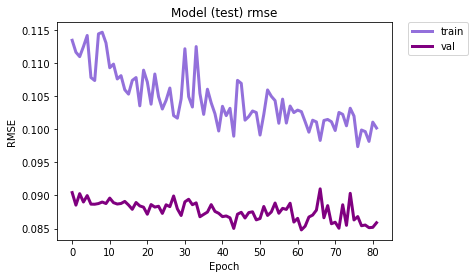

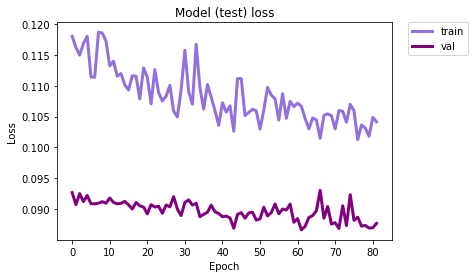

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.9462127
Transformed yhat 73.25577
yhat 0.9492998
Transformed yhat 73.298485
yhat 0.94924176
Transformed yhat 73.297676
yhat 0.9484975
Transformed yhat 73.287384
yhat 0.94793177
Transformed yhat 73.27956
yhat 0.9476834
Transformed yhat 73.276115
yhat 0.9476545
Transformed yhat 73.27572
yhat 0.9477287
Transformed yhat 73.27674
yhat 0.9478378
Transformed yhat 73.27825
yhat 0.9479343
Transformed yhat 73.279594
yhat 0.9480145
Transformed yhat 73.2807
yhat 0.9480756
Transformed yhat 73.28155
Real data: [73.         73.         73.         73.         73.2745098  72.30769231
 71.56862745 73.19230769 71.60784314 72.90196078 73.         73.
 73.         73.         73.         73.         73.         73.
 73.         73.         73.         73.         73.         73.        ]
Forecasting values: [73.3, 73.3, 73.3, 73.3, 73.3, 73.3, 73.3, 73.3, 73.3, 73.3, 73.3, 73.3]


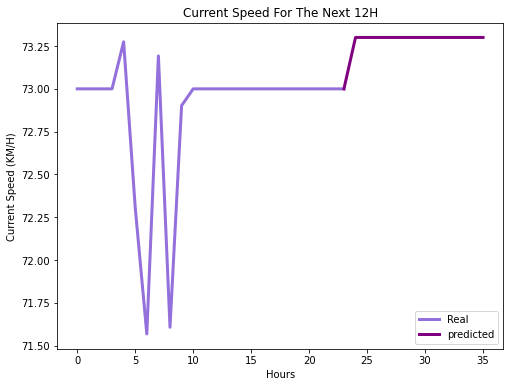

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N101.0',forecastSpeed[i],hour[i]
        writer.writerow(d)